In [2]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

策略编写步骤
设置回测模式，日期，品种数据
设置品种，手续费，滑点
设置策略参数
初始化策略
编写指标信号
下单执行
执行回测
显示回测结果

In [5]:
#创建回测引擎
engine= BacktestingEngine()
engine.setDB_URI("mongodb://localhost:27017")
#设置回测模式
engine.setBacktestingMode(engine.BAR_MODE)
engine.setDatabase('VnTrader_1Min_Db')
# 设置回测日期，initHours 默认值为 0
engine.setStartDate('20180201 23:00:00',initHours=10)
engine.setEndDate('20190320 23:00:00')
#设置交易品种，手续费，滑点
engine.setCapital(10000000)
constracts=[{"symbol":"IF88:CTP",
                "size" : 1, # 每点价值
                "priceTick" : 0.1, # 最小价格变动
                "rate" : 5/10000, # 单边手续费
                "slippage" : 0.1 # 滑价
            },]
engine.setContracts(constracts)
settingList = [{
                "symbolList": ["IF88:CTP"]
                }]

In [13]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
from datetime import datetime
#策略继承ctaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    symbolList = ["IF88:CTP"]
    #策略参数
    fastPeriod=20
    slowPeriod=55
    lot=1#设置手数
    #策略变量
    transactionPrice=None
    paramList=['fastPeriod','slowPeriod']
    #策略变量列表
    varList=['transactionPrice']
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象?????????
    def onInit(self):
        """初始化策略"""
        self.transactionPrice={s:0 for s in self.symbolList}#生成成交价格的字典
        self.chartLog= {
                        'datetime':[],
                        'fastMa':[],
                        'slowMa':[]
                        }
        self.putEvent()
    
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    def onStop(self):
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        # 计算策略需要的信号-------------------------------------------------
        fastMa=ta.EMA(am60.close,self.fastPeriod)
        slowMa=ta.EMA(am60.close,self.slowPeriod)
        self.chartLog['datetime'].append(datetime.strptime(am60.datetime[-1], "%Y%m%d %H:%M:%S"))
        self.chartLog['fastMa'].append(fastMa[-1])
        self.chartLog['slowMa'].append(slowMa[-1])
        #设置交易条件
        crossOver=(fastMa[-1]>slowMa[-1]) and (fastMa[-2]<=slowMa[-2])
        crossBlow=(fastMa[-1]<slowMa[-1]) and (fastMa[-2]>=slowMa[-2])
         # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            if self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol,bar.close*1.01,self.lot)
            elif self.posDict[symbol+'_SHORT']>0:
                self.cancelAll()#撤销挂单，撤销要卖出的单子
                self.cover(symbol,bar.close*1.01,self.posDict[symbol+'_SHORT'])
                self.buy(symbol,bar.close*1.01,self.lot)
        #如果死叉时候没有空头持仓
        elif (crossBlow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol,bar.close*0.99,self.lot)
            elif self.posDict[symbol+'_LONG']>0:
                self.cancelAll()
                self.cover(symbol,bar.close*0.99,self.posDict[symbol+'_LONG'])
                self.short(symbol,bar.close*0.99,self.lot)
        self.putEvent()
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass
            
                                         

In [14]:
from vnpy.trader.utils import htmlplot
engine.setLog(True, "./log")
engine.initStrategy(DoubleMaStrategy, settingList[0])
# 开始跑回测
engine.runBacktesting()

初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-05-17 20:13:41.440579	开始回测
2019-05-17 20:13:41.441581	策略初始化
2019-05-17 20:13:41.445592	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-05-17 20:13:41.466648	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-05-17 20:13:41.481686	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:13:41.482691	载入完成, 数据量:120
2019-05-17 20:13:41.482691	初始化预加载数据成功, 数据长度:120
2019-05-17 20:13:41.482691	策略初始化完成
2019-05-17 20:13:41.483693	策略启动完成
2019-05-17 20:13:41.483693	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-05-17 20:13:41.483693	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-05-17 20:13:43.887381	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-05-17 20:13:51.385326	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-05-17 20:13:53.794735	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:13:53.812803	载入完成, 数据量:65040
2019-05-17 20:13:53.871960	准备载入数据：时间段:[20180201 07:51:00 , 20180203 23:01:00), 模式: bar
2019-05-17 20:13:53.936111	

# def initStrategy(self, strategyClass, setting=None):
        """
        初始化策略
        setting是策略的参数设置，如果使用类中写好的默认设置则可以不传该参数
        """
        self.strategy = strategyClass(self, setting)
        self.strategy.name = self.strategy.className
        self.strategy.symbolList = setting['symbolList']
        self.initPosition(self.strategy)

2019-05-17 20:24:46.640569	计算回测结果
2019-05-17 20:24:46.656612	交割单已生成
2019-05-17 20:24:46.657615	------------------------------
2019-05-17 20:24:46.657615	第一笔交易：	2018-03-23 09:30:00
2019-05-17 20:24:46.657615	最后一笔交易：	2019-03-20 14:58:00
2019-05-17 20:24:46.658618	总交易次数：	8
2019-05-17 20:24:46.658618	总盈亏：	67.18
2019-05-17 20:24:46.659621	最大回撤: 	-300.18
2019-05-17 20:24:46.659621	平均每笔盈利：	8.4
2019-05-17 20:24:46.660623	平均每笔滑点：	0.2
2019-05-17 20:24:46.660623	平均每笔佣金：	3.48
2019-05-17 20:24:46.661625	胜率		87.5%
2019-05-17 20:24:46.661625	盈利交易平均值	52.48
2019-05-17 20:24:46.661625	亏损交易平均值	-300.18
2019-05-17 20:24:46.661625	盈亏比：	0.17
2019-05-17 20:24:47.023951	策略回测统计图已保存


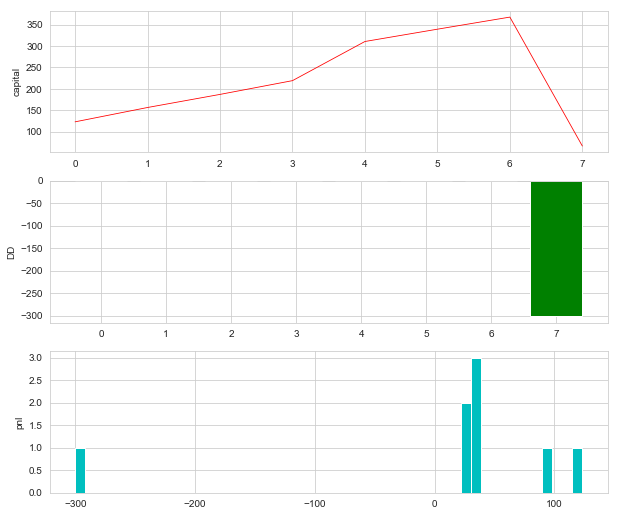

In [15]:
#显示回测的每张订单数
engine.showBacktestingResult()

2019-05-17 20:25:42.543961	计算按日统计结果
2019-05-17 20:25:42.612218	------------------------------
2019-05-17 20:25:42.612218	首个交易日：	2018-02-02
2019-05-17 20:25:42.612218	最后交易日：	2019-03-20
2019-05-17 20:25:42.612218	总交易日：	271
2019-05-17 20:25:42.612218	盈利交易日	115
2019-05-17 20:25:42.612218	亏损交易日：	127
2019-05-17 20:25:42.612218	起始资金：	10000000
2019-05-17 20:25:42.612218	结束资金：	10,000,069.2
2019-05-17 20:25:42.612218	总收益率：	0.0%
2019-05-17 20:25:42.612218	年化收益：	0.0%
2019-05-17 20:25:42.612218	总盈亏：	69.2
2019-05-17 20:25:42.612218	最大回撤: 	-805.0
2019-05-17 20:25:42.612218	百分比最大回撤: -0.01%
2019-05-17 20:25:42.612218	总手续费：	25.9
2019-05-17 20:25:42.612218	总滑点：	1.5
2019-05-17 20:25:42.612218	总成交金额：	51,803.8
2019-05-17 20:25:42.612218	总成交笔数：	15
2019-05-17 20:25:42.612951	日均盈亏：	0.26
2019-05-17 20:25:42.612951	日均手续费：	0.1
2019-05-17 20:25:42.612951	日均滑点：	0.01
2019-05-17 20:25:42.612951	日均成交金额：	191.16
2019-05-17 20:25:42.612951	日均成交笔数：	0.06
2019-05-17 20:25:42.612951	日均收益率：	0.0%
2019-05-17 20:25:42.612951	收益标

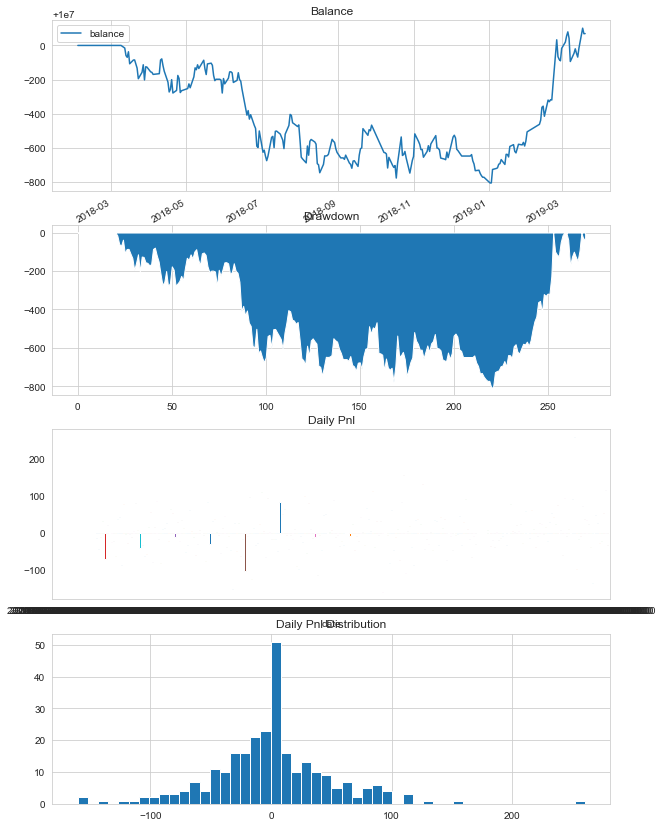

In [16]:
# 显示回测的每日绩效
engine.showDailyResult()

In [18]:
chartLog=pd.DataFrame(engine.strategy.chartLog).set_index('datetime')
mp = htmlplot.getMultiPlot(engine, freq="60m")
mp.set_line(line=chartLog[['fastMa', 'slowMa']], colors={"fastMa": "red",'slowMa':'blue'}, pos=0)
mp.show()

优化策略参数
单线程运行优化
多线程优化

In [20]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
#优化配置
setting=OptimizationSetting()
engine.setLog(False)
setting.setOptimizeTarget('sharpeRatio')
setting.addParameter('fastPeriod', 20, 40, 10)    # 增加第一个优化参数，起始30，结束50，步进10
setting.addParameter('slowPeriod', 40, 80, 20)    # 增加第二个优化参数，起始60，结束30，步进10
setting.addParameter('symbolList', ['IF88:CTP'])

In [24]:
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(DoubleMaStrategy, setting)

print('耗时：%s' %(time.time()-start))

2019-05-17 20:54:42.662822	------------------------------
2019-05-17 20:54:42.662822	setting: {'fastPeriod': 20, 'slowPeriod': 40, 'symbolList': ['IF88:CTP']}
初始仓位: {'IF88:CTP_LONG': 0, 'IF88:CTP_SHORT': 0}
2019-05-17 20:54:42.663826	开始回测
2019-05-17 20:54:42.663826	策略初始化
2019-05-17 20:54:42.666833	准备载入数据：时间段:[20180201 13:00:00 , 20180201 23:00:00), 模式: bar
2019-05-17 20:54:42.691898	IF88:CTP： 从本地缓存文件实取120, 最大应取600, 还需从数据库取480
2019-05-17 20:54:42.714959	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:54:42.714959	载入完成, 数据量:120
2019-05-17 20:54:42.714959	初始化预加载数据成功, 数据长度:120
2019-05-17 20:54:42.714959	策略初始化完成
2019-05-17 20:54:42.714959	策略启动完成
2019-05-17 20:54:42.714959	回测时间范围:[20180201 23:00:00,20190320 23:00:00)
2019-05-17 20:54:42.714959	当前回放的时间段:[20180201 23:00:00,20190320 23:00:00)
2019-05-17 20:54:45.174560	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-05-17 20:54:53.361523	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-05-17 20:54:56.142920	IF88:CTP： 数据库也没能补到缺失的数

2019-05-17 20:55:46.051191	准备载入数据：时间段:[20180201 23:00:00 , 20190320 23:00:00), 模式: bar
2019-05-17 20:55:54.171793	IF88:CTP： 从本地缓存文件实取65040, 最大应取593280, 还需从数据库取528240
2019-05-17 20:55:56.804822	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:55:56.826854	载入完成, 数据量:65040
2019-05-17 20:55:56.888024	准备载入数据：时间段:[20180201 07:51:00 , 20180203 23:01:00), 模式: bar
2019-05-17 20:55:56.945169	IF88:CTP： 从本地缓存文件实取480, 最大应取3790, 还需从数据库取3310
2019-05-17 20:55:56.966225	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:55:56.966225	载入完成, 数据量:480
2019-05-17 20:55:57.229985	准备载入数据：时间段:[20171226 02:00:00 , 20180201 07:50:00), 模式: bar
2019-05-17 20:55:57.932874	IF88:CTP： 从本地缓存文件实取6240, 最大应取53630, 还需从数据库取47390
2019-05-17 20:55:58.125386	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:55:58.127411	载入完成, 数据量:6240
2019-05-17 20:55:58.132404	准备载入数据：时间段:[20180203 23:02:00 , 20180204 00:00:00), 模式: bar
2019-05-17 20:55:58.133414	IF88:CTP： 从本地缓存文件实取0, 最大应取58, 还需从数据库取58
2019-05-17 20:55:58.157491	IF88:CTP： 数据库也没能补到缺失的数据
2019-05-17 20:55:58.157491	

KeyboardInterrupt: 

In [ ]:
print(pd.DataFrame(resultList).sort_values(1,  ascending=False))